# Notebook to CQWS calculations

In [2]:
import sys
import os
import numpy as np
from numpy import linalg as LA
import scipy.constants
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
import glob as glob
import SolverCQWsPoisson as solver
from IPython.display import display, Math
from tabulate import tabulate
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

q = 1.602176e-19 #C
kb = 1.3806504e-23 #J/K
nii = 0.0
hbar = 1.054588757e-34
m_e= 9.1093826E-31 #kg
m0= 9.1093826E-31 #kg
pi=np.pi
eps0= 8.8541878176e-12 #F/m
J2meV=1e3/q
from thomas_solve  import TDMA
plt.style.use('/media/labfiles/lab-codes/plotstyle.mplstyle')
plt.rc( 'text', usetex=True ) 
plt.rc('font',family = 'sans-serif',  size=25)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')


# SCHRODINGER-POISSON Solver

These codes were performed from two sources and modified to converging in our structures.  Is  important to mentioned  that the structures with high doped ($n>1\times 10^{18}$) and large, they usually cause divergence in this self-consistent calculations.  

Sources: <br>

https://github.com/aestimosolver/aestimo-edu <br>
H. Hebal, Z. Koziol, S.B. Lisesivdin, and R. Steed “General-purpose open-source 1D self-consistent Schrödinger-Poisson Solver: Aestimo 1D” Comput. Mater. Sci. 186, 110015 (2021).


https://github.com/qpv-research-group/solcore5 <br>
D. Alonso-Álvarez, T. Wilson, P. Pearce, M. Führer, D. Farrell, N. Ekins-Daukes, Journal of Computational Electronics (2018).



In [3]:
from scipy.sparse import dia_matrix

class schro:
    def __init__(self,model,pote,particle='e'):
        self.dx       = model.dx
        self.dz       = model.dx
        self.n        = model.n_max
        self.subbands = model.subbands 
        self.xaxis    = model.xaxis
        self.z        = model.xaxis
        self.Fapp     = model.Fapp
        self.T           = model.T
        self.pote     = pote+self.Fapp*q*self.xaxis
        if particle=='e':
            self.me       = model.cb_meff
            self.Qc       = model.Qc
        elif particle=='hh':
            self.me       = model.vbhh_meff
            self.Qv       = model.Qv
        elif particle=='lh':
            self.me       = model.vblh_meff
            self.Qv       = model.Qv
        self.material  = model.material
    
        
    def QuantumSolutions(self):
            #self.xe    = np.zeros(self.subbands)
            #self.xpsi  = np.zeros((self.n,self.subbands))
            self.cb = self.pote
            #self.Hamiltonian_e  = H(self.cb,self.me,self.Fapp,self.dx,self.n)
            # Eigenvalues and Eigenvectors to electrons in Conduction bands
            #upper_e       = np.diag(self.Hamiltonian_e,k=1)
            #diagonal_e    = np.diag(self.Hamiltonian_e,k=0)
            #lower_e       = np.diag(self.Hamiltonian_e,k=-1)
            #Hn_e          = scipy.sparse.diags(H_diags_e, [-1,0,1], format='csc')
            #self.ew,self.psiw= eigs(Hn_e,k=self.subbands, which='LR', sigma=sigma)
            # We shift the potential so that it is possitive with the minimum value around zero
            q=1.60217646e-19
            h=6.626068e-34
            hbar=1.05457148e-34
            m0=9.10938188e-31
            fe =self.pote
            z = self.xaxis
            l = max(z)
            e0 = hbar ** 2 / (m0 * l ** 2)
            quasiconfined=0.0
            dz = np.gradient(z / l)
            N = len(fe)
            offset = np.amin(fe)
            fe = (fe - offset)/e0
            m = self.me/m0
            # Vectorise effective mass differences to avoid a loop
            m = np.insert(m, (0, len(m)), (m[0], m[-1]))
            m_a = m[0:-2]  # m_(j-1) from Frensley, W. R. (1991)
            m_b = m[1:-1]  # m_j
            m_c = m[2:]  # m_(j+1)
            # These are the interior diagonals of equation 18 in the above ref.
            axis = 0.25 / dz ** 2 * (
            1 / m_a + 2 / m_b + 1 / m_c) + fe   # d_j from Frensley, W. R. (1991), modified to include kt and normalised variables
            upper = 0.25 / dz ** 2 * (1 / m_a + 1 / m_b)  # s_(j+1)
            lower = 0.25 / dz ** 2 * (1 / m_b + 1 / m_c)  # s_j

            index = (-1, 0, 1)
            diagonals = (-lower, axis, -upper)
            H = dia_matrix((diagonals, index), shape=(N, N))
            sigma=0.0
            num=(self.subbands,self.subbands)
            E, Psi = eigs(H, k=num[0], which='LR', sigma=sigma)
            potmax = max(fe) + quasiconfined * q / e0
            if quasiconfined < 0.0:
                potmax = max(E)
            confined_levels = [i for i, e in enumerate(E) if (e < potmax and i < num[1])]
            E = E[confined_levels].real
            Psi = np.array(Psi[:, confined_levels])
            #Psi = [p / np.sqrt(np.trapz(p*p.conjugate(), x=z.T)) for p in Psi.real]
            E = E * e0 + offset
            
            for i in range(len(confined_levels)):
                Psi[:,i] = Psi[:,i]/np.sqrt(np.trapz(abs(Psi[:,i])**2))
            
            class Results(): pass
            results          = Results()
            results.z        = z
            results.psi      = Psi.real
            results.e        = np.array(E)
            results.cb       = self.pote
            results.dx       = dz
            results.subbands = confined_levels 
            return results

Total layer number: 3
500


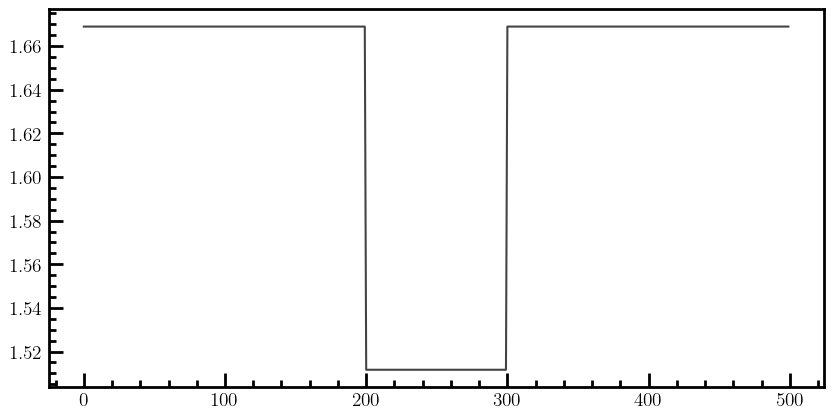

CPU times: user 434 ms, sys: 7.27 ms, total: 442 ms
Wall time: 612 ms


In [4]:
%%time
from solvercqws import H
import solvercqws as solver
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh

class Structure(object): pass
sem01 = Structure() # this will be our datastructure
# TEMPERATURE
sem01.T =60#Kelvin
# Binding Energy
# Band Offset ratios
sem01.Qc = 0.65
sem01.Qv = 0.35
# Total subband number to be calculated for electrons
sem01.subbands = 10
# APPLIED ELECTRIC FIELD
sem01.Fapp = 0e5 # (V/m)
# For 1D, z-axis is choosen
sem01.gridfactor =0.1#nm
## REGIONS
## Region input is a two-dimensional list input.
##         | Thickness (nm) | Material | Alloy fraction | Doping(cm^-3) | n or p type |

sem01.ctest1=1e-5
sem01.damped_factor=1e-1


width=600.0
# sem01.material =[
#          [200.0,'GaAs'  ,     0,   0e18, 'i','w'],
#          [width, 'AlGaAs',   0.15,  6e18, 'n','b'],
#          [300.0, 'AlGaAs',   0.15,  0e18, 'i','b'],
#          [11.87,'GaAs'  ,     0,   0e18, 'i','w'],
#          [1.98, 'AlGaAs',   0.15,  0e18, 'i','b'],
#          [23.74,'GaAs'  ,     0,   0e18, 'i','w'],
#          [300.0, 'AlGaAs',   0.15,  0e18, 'i','b'],
#          [10.0,'GaAs'  ,     0,   0e18, 'i','w'],
# ]
sem01.material =[
         [20.0, 'AlGaAs',   0.2,  0e17, 'i','b'],
         [10.0,'GaAs'  ,     0,   2e18, 'n','w'],
         [20.0, 'AlGaAs',   0.2,  0e17, 'i','b'],
]


# sem01.material =[
#          [10.0,'GaAs'  ,     0,   1.3e18, 'i','w'],
#          [20.0, 'AlGaAs',   0.31,  1.3e18, 'i','b'],
#          [2.5,'GaAs'  ,     0,  1e18, 'n','w'],
#          [45, 'AlGaAs',   0.31,  1e18, 'i','b'],
#          [2.5,'GaAs'  ,     0,   1e18, 'm','w'],
# ]
sem01.material
str01 = sem01
nm = 1e-9
# RUN SIMULATION
model01 = solver.StructureFrom(str01) #
#model01.cb = model01.cb-np.min(model01.cb)
print(len(model01.xaxis))
plt.plot(model01.xaxis/1e-10,model01.cb/q)
plt.show()

In [5]:
#--------------------------------- Poisson SOLVER 
from math import log, exp
from IPython.display import display, clear_output

# Defining constants and material parameters
q = 1.602176e-19  # C
kb = 1.3806504e-23  # J/K
hbar = 1.054588757e-34
pi = np.pi
eps0 = 8.8541878176e-12  # F/m
J2eV = 1 / q  # Joules to meV
eV2J = 1 * q  # meV to Joules
J2meV = 1e3 / q  # Joules to meV
meV2J = 1e-3 * q  # meV to Joules
def fd2(Ei,Ef,T):
    """integral of Fermi Dirac Equation for energy independent density of states.
    Ei [meV], Ef [meV], T [K]"""
    return kb * T * log(exp(meV2J * (Ef - Ei) / (kb * T)) + 1)

def fermilevel_0K(Ntotal2d, E_state, meff_state):
    Et, Ef = 0.0, 0.0
    for i, (Ei, csb_meff) in enumerate(zip(E_state, meff_state)):
        Et += Ei
        Efnew = (Ntotal2d * hbar ** 2 * pi / csb_meff * J2meV + Et) / (i + 1)
        if Efnew > Ei:
            Ef = Efnew
        else:
            break  # we have found Ef and so we should break out of the loop
    else:  # exception clause for 'for' loop.
        print(
            "Have processed all energy levels present and so can't be sure that Ef is below next higher energy level."
        )
    N_state = [0.0] * len(E_state)
    for i, (Ei, csb_meff) in enumerate(zip(E_state, meff_state)):
        Ni = (Ef - Ei) * csb_meff / (hbar ** 2 * pi) * meV2J  # populations of levels
        Ni *= Ni > 0.0
        N_state[i] = Ni
    return (
        Ef,
        N_state,
    )  # Fermi levels at 0K (meV), number of electrons in each subband at 0K


def fermilevel(Ntotal2d, T, E_state, meff_state):
    """Finds the Fermi level (meV)"""
    # parameters
    FD_d_E =1e-5
    FD_convergence_test =  1e-5

    def func(Ef, E_state, meff_state, Ntotal2d, T):
        # return Ntotal2d - sum( [csb_meff*fd2(Ei,Ef,T) for Ei,csb_meff in zip(E_state,meff_state)] )/(hbar**2*pi)
        diff = Ntotal2d
        for Ei, csb_meff in zip(E_state, meff_state):
            diff -= csb_meff * fd2(Ei, Ef, T) / (hbar ** 2 * pi)
        return diff

    Ef_0K, N_states_0K = fermilevel_0K(Ntotal2d, E_state, meff_state)
    # Ef=fsolve(func,Ef_0K,args=(E_state,meff_state,Ntotal2d,T))[0]
    # return float(Ef)
    # implement Newton-Raphson method
    Ef = Ef_0K
    d_E = FD_d_E  # Energy step (meV)
    while True:
        y = func(Ef, E_state, meff_state, Ntotal2d, T)
        dy = (
            func(Ef + d_E, E_state, meff_state, Ntotal2d, T)
            - func(Ef - d_E, E_state, meff_state, Ntotal2d, T)
        ) / (2.0 * d_E)
        if (
            dy == 0.0
        ):  # increases interval size for derivative calculation in case of numerical error
            d_E *= 2.0
            continue  # goes back to start of loop, therefore d_E will increase until a non-zero derivative is found
        Ef -= y / dy
        if abs(y / dy) < FD_convergence_test:
            break
        # reduces the interval by a couple of notches ready for the next iteration
        for i in range(2):
            if d_E > FD_d_E:
                d_E *= 0.5
    return Ef  # (meV)

def calc_meff_state(wfe,cb_meff):
    """find subband effective masses"""
    tmp=[]
    for i in range(wfe.shape[1]):
        tmp.append(1.0/np.sum(wfe[:,i]**2/cb_meff))
    meff_state = tmp
    return meff_state #kg

def calc_N_state(Ef, T, Ns, E_state, meff_state):
    # Find the subband populations, taking advantage of step like d.o.s. and analytic integral of FD
    N_state = [fd2(Ei, Ef, T) * csb_meff / (hbar ** 2 * pi)for Ei, csb_meff in zip(E_state, meff_state)]
    return N_state  # number of carriers in each subband

def calc_sigma(wfe,N_state,model,subbands):
    """This function calculates `net' areal charge density
    n-type dopants lead to -ve charge representing electrons, and additionally 
    +ve ionised donors."""
    # note: model.dop is still a volume density, the delta_x converts it to an areal density
    sigma= model.dop*model.dx # The charges due to the dopant ions
    dop      = model.dop
    dx       = model.dx
    Ntotal   = sum(dop) # calculating total doping density m^-3
    Ntotal2d = Ntotal*dx
    for j in range(wfe.shape[1]): # The charges due to the electrons in the subbands
        sigma-= N_state[j]*abs(wfe[:,j])**2
    return sigma #charge per m**2 per dz (units of electronic charge)
    
##
def calc_field(sigma, eps):
    """calculate electric field as a function of z-
    sigma is a number density per unit area
    eps is dielectric constant"""
    # i index over z co-ordinates
    # j index over z' co-ordinates
    # Note:
    F0 = -np.sum(q * sigma) / (2.0)  # CMP'deki i ve j yer değişebilir - de + olabilir
    # is the above necessary since the total field due to the structure should be zero.
    # Do running integral
    tmp = (np.hstack(([0.0], sigma[:-1])) + sigma)  # using trapezium rule for integration (?).
    tmp *= ( q / 2.0 )  # Note: sigma is a number density per unit area, needs to be converted to Couloumb per unit area
    tmp[0] = F0
    F = np.cumsum(tmp) / (eps)                        
    return F  # electric field

def calc_potn(F,dx):
    """This function calculates the potential (energy actually)"""
    # V electric field as a function of z-
    # i	index over z co-ordinates

    #Calculate the potential, defining the first point as zero
    tmp = q*F*dx
    V = np.cumsum(tmp) #+q -> electron -q->hole? 
    return V
def calc_periodic_potn(V, eps, dx):
    """Alters a potential so that it is periodic across the structure.
    V - potential (array)
    eps - dielectric constant (array)
    dx - step size (nm)"""
    pseudoz = np.cumsum(dx / eps)
    return V[-1] / pseudoz[-1] * pseudoz


def poisson(model):
    potini = model.cb
    Fapp = model.Fapp
    meff = model.cb_meff
    dx = model.dx
    n = model.n_max
    subbands = len(schro(model,potini).QuantumSolutions().subbands)
    eps = model.eps
    dop = model.dop
    T = model.T
    max_iterations   = 2000
    convergence_test = model.ctest1
    damped_factor=model.damped_factor
    # create arrays 
    xaxis =model.xaxis      #metres
    vtot = np.zeros(n)  
    v = np.zeros(n)  
    # Setup the doping
    Ntotal = sum(dop) # calculating total doping density m^-3
    Ntotal2d = Ntotal*dx # m^-3 to m^-2
    print( 'N total: %.1E' %( sum(dop) * dx))
    # iterations
    iteration = 0
    vtot = model.cb
    olde0 = 0 
    F=0
    damping=damped_factor
    while True:
        # Primero calculamos eigen-energias y funciones de onda resolviendo la eq de Schrodinger
        e = schro(model,vtot).QuantumSolutions().e*J2meV 
        psi = schro(model,vtot).QuantumSolutions().psi
        # Calculamos el nivel de fermi para la densidad de electrones
        meff_state =calc_meff_state(psi,meff)
        Ef         =fermilevel(Ntotal2d,T,e, meff_state)
        if Ef == np.inf:
            print(' Quasi Fermi-Level diverge')
            break
        else:
            print('Fermi level  : %g meV' %(Ef/1000))
        N_state    = calc_N_state(Ef,T,Ntotal2d,e,meff_state)
        sigma      = calc_sigma(psi,N_state,model,subbands)
        F          = calc_field(sigma,eps)
        vnew       = calc_potn(F,dx)
        v +=  damping * (vnew - v)
        vtot =(model.cb+v)
            
        if abs(e[0] - olde0) < convergence_test:  # Convergence test
            print('Donor charge : %g m**-2' %( sum(dop) * dx))
            print('Level charge : %g m**-2' %(sum(N_state)))
            print('System charge: %g m**-2' %(sum(sigma)))
            print("Ec min       : %g eV"%(np.min(potini)*J2meV/1000 ))
            print("Ec max       : %g eV"%(np.max(potini)*J2meV/1000 ))
            print('error        : %g eV'%(abs(e[0]-olde0)))
            print('old e0       : %g eV'%(olde0/1000))
            print("Iterations   : %d"%iteration)
            break
        elif iteration >= max_iterations:  # Iteration limit
            print("Have reached maximum number of iterations")
            break
        else:
            print('Donor charge : %g m**-2' %( sum(dop) * dx))
            print('Level charge : %g m**-2' %(sum(N_state)))
            print('System charge: %g m**-2' %(sum(sigma)))
            print("Ec min       : %g eV"%(np.min(potini)*J2meV/1000 ))
            print("Ec max       : %g eV"%(np.max(potini)*J2meV/1000 ))
            print('error        : %g eV'%(abs(e[0]-olde0)))
            print('old e0       : %g eV'%(olde0/1000))
            print("Iterations   : %d"%iteration)
            iteration += 1
            olde0 = e[0]
        clear_output(wait=True)

            
    class Results(): pass
    results = Results()
    results.vini = potini
    results.z = xaxis
    results.psie = psi
    results.en = e/1000
    results.vtot  = vtot
    results.sigma = sigma
    results.vnew = vnew
    results.v = v
    results.field    = F
    results.t = T
    results.dx = dx
    results.subbands = subbands
    results.meff = meff_state
    results.fermi = Ef
    return results

results = poisson(model01)


Fermi level  : 1.61203 meV
Donor charge : 2e+16 m**-2
Level charge : 2e+16 m**-2
System charge: -44765.2 m**-2
Ec min       : 1.51163 eV
Ec max       : 1.66895 eV
error        : 6.82948e-06 eV
old e0       : 1.54142 eV
Iterations   : 64


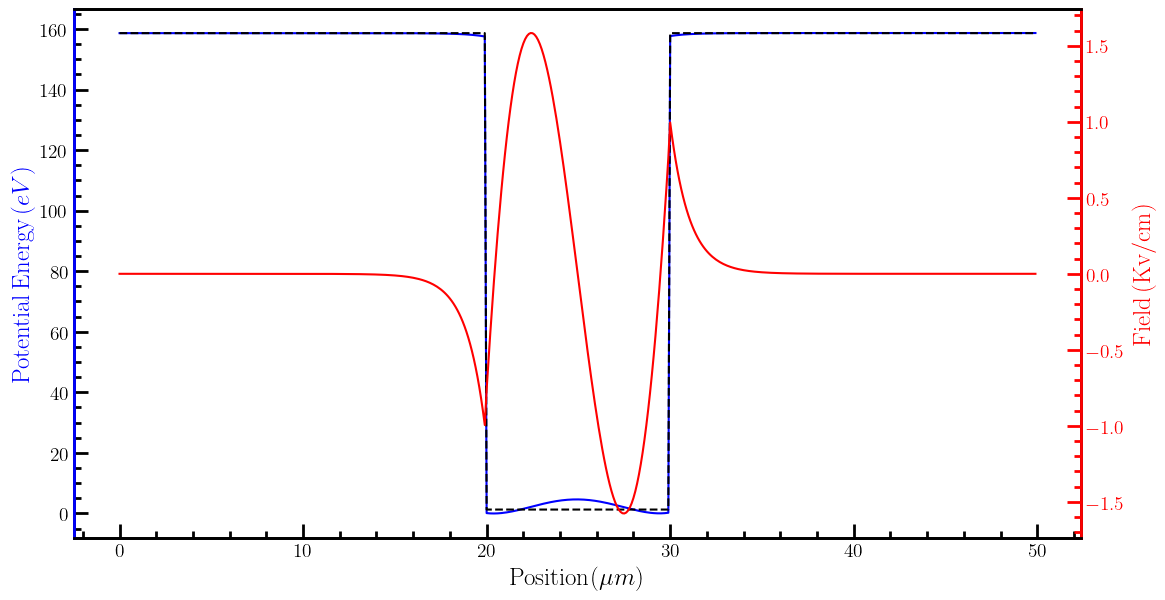

In [29]:
off = max(results.vtot/q)-(max(results.vtot/q)-min(results.vtot/q))
pxi=5300;pxf=5900
fig, ax1 = plt.subplots(figsize=(13,7))
line1, = ax1.plot(results.z/1e-9,1e3*((results.vtot/q)-off),'b')
line1, = ax1.plot(results.z/1e-9,1e3*((results.vini/q)-off),'--k')

ax1.set_xlabel(r"$\mathrm{Position} (\mu m)$")
ax1.set_ylabel(r"$\mathrm{Potential\, Energy}\, (eV)$",color='b')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
line2, =ax2.plot(results.z/1e-9, results.field/1e6, color='r')
ax2.set_ylabel(r"$\mathrm{Field}\, (\mathrm{Kv/cm})$",color='r')

ax2.spines["right"].set_color('r')
ax2.spines["left"].set_color('b')
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')
ax1.tick_params(direction="in", which="both", colors=line1.get_color())
ax2.tick_params(direction="in", which="both", colors=line2.get_color())

plt.show()

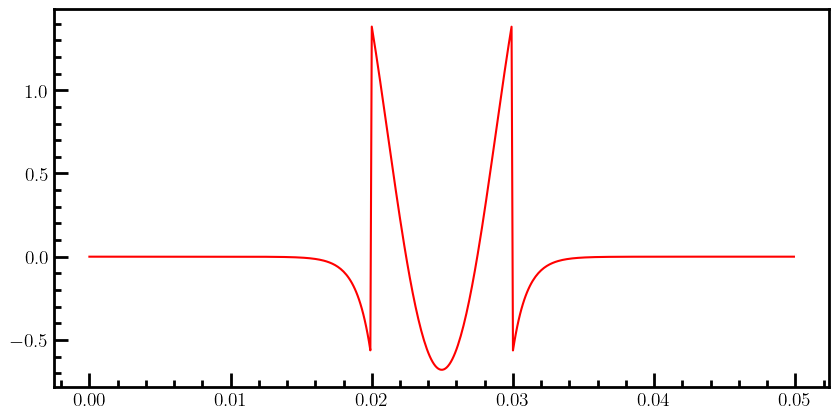

In [7]:
plt.plot(results.z/1e-6, results.sigma/1e14, color='r')

In [40]:
expdata1 = np.array([results.z/1e-9,1e3*((results.vtot/q)-off),1e3*((results.vini/q)-off)]).T
expdata2 = np.array([results.z/1e-9,results.sigma/1e14,results.field/1e6]).T

np.savetxt('harrison-data/data1.dat',expdata1,delimiter=',')
np.savetxt('harrison-data/data2.dat',expdata2,delimiter=',')

In [48]:
class Structure(object): pass
sem02 = Structure() # this will be our datastructure
# TEMPERATURE
sem02.T = 293.0#Kelvin
# Binding Energy
# Band Offset ratios
sem02.Qc = 0.65
sem02.Qv = 0.35
# Total subband number to be calculated for electrons
sem02.subbands = 50
# APPLIED ELECTRIC FIELD
sem02.Fapp = 0 # (V/m)
# For 1D, z-axis is choosen
sem02.gridfactor =0.1#nm
# REGIONS
# Region input is a two-dimensional list input.
#         | Thickness (nm) | Material | Alloy fraction | Doping(cm^-3) | n or p type |
sem02.ctest1=1e-4
sem02.damped_factor=1e-2

sem02.material =[
         [20.0, 'AlGaAs',   0.4,  1.3e18, 'i','b'],
         [3.0,'GaAs'  ,     0,   1.33e18, 'n','w'],
         [25.0, 'AlGaAs',   0.4,  1.3e18, 'i','b'],
         [7,'GaAs'  ,     0,   0e18, 'i','w'],
         [15, 'AlGaAs',   0.2,  0e18, 'i','b'],
         [5,'GaAs'  ,     0,   0e18, 'i','w'],
         [25.0, 'AlGaAs',   0.4,  1.3e18, 'i','b'],
         [3.0,'GaAs'  ,     0,   1.33e18, 'n','w'],
         [20.0, 'AlGaAs',   0.4,  1.33e18, 'i','b'],
]
sem02.material
str02 = sem02
nm = 1e-9
# RUN SIMULATION
model02 = solver.StructureFrom(str02) #
#model01.cb = model01.cb-np.min(model01.cb)
print(len(model02.xaxis))


results2 = poisson(model02)


Fermi level  : 1.5298 meV
Donor charge : 7.98e+15 m**-2
Level charge : 7.98e+15 m**-2
System charge: -5.73384e+07 m**-2
Ec min       : 1.42564 eV
Ec max       : 1.68917 eV
error        : 9.23026e-05 eV
old e0       : 1.55607 eV
Iterations   : 279


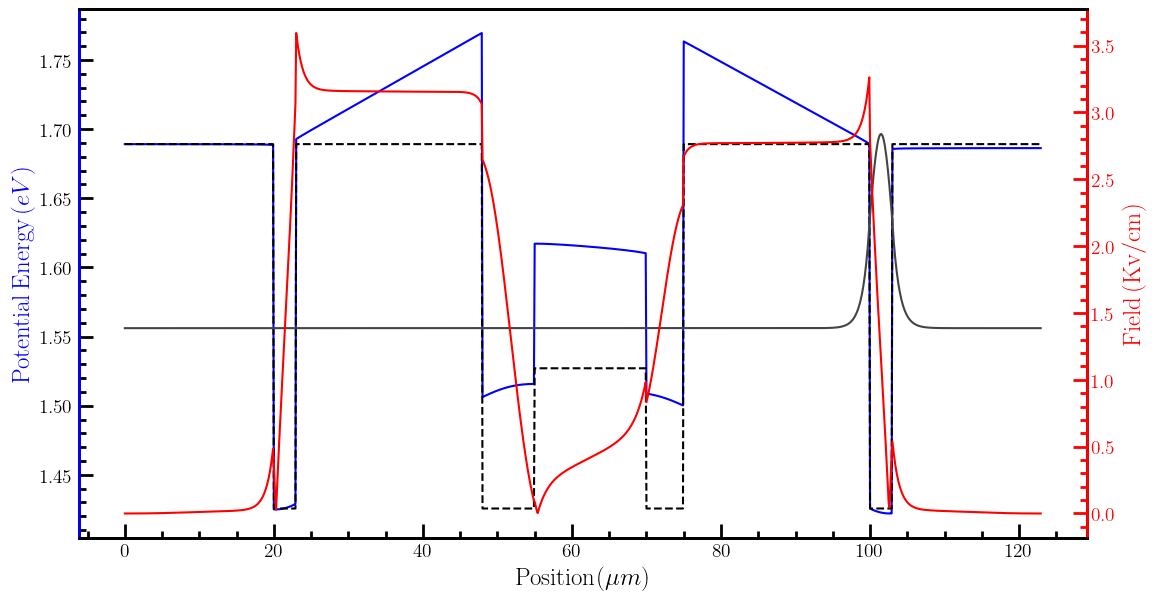

In [49]:
off = 0
fig, ax1 = plt.subplots(figsize=(13,7))
line1, = ax1.plot(results2.z/1e-9,((results2.vtot/q)-off),'b')
line1, = ax1.plot(results2.z/1e-9,((results2.vini/q)-off),'--k')


ax1.plot(results2.z/1e-9,5*abs(results2.psie[:,0])**2 + results2.en[0],)

ax1.set_xlabel(r"$\mathrm{Position} (\mu m)$")
ax1.set_ylabel(r"$\mathrm{Potential\, Energy}\, (eV)$",color='b')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
line2, =ax2.plot(results2.z/1e-9, abs(results2.field/1e6), color='r')
ax2.set_ylabel(r"$\mathrm{Field}\, (\mathrm{Kv/cm})$",color='r')




ax2.spines["right"].set_color('r')
ax2.spines["left"].set_color('b')
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')
ax1.tick_params(direction="in", which="both", colors=line1.get_color())
ax2.tick_params(direction="in", which="both", colors=line2.get_color())

plt.show()

In [50]:
expdata1 = np.array([results2.z/1e-9,(results2.vtot/q),(results2.vini/q)]).T
expdata2 = np.array([results2.z/1e-9,results2.sigma,results2.field/1e6,abs(results2.field/1e6)]).T

expdata3 = np.array([results2.z/1e-9,5*abs(results2.psie[:,0])**2 + results2.en[0],5*abs(results2.psie[:,2])**2 + results2.en[2]]).T

np.savetxt('khakshoor-data/data1.dat',expdata1,delimiter=',')
np.savetxt('khakshoor-data/data2.dat',expdata2,delimiter=',')
np.savetxt('khakshoor-data/data3.dat',expdata3,delimiter=',')

In [ ]:
fig, ax1 = plt.subplots(figsize=(13,10))
line1, = ax1.plot(results.z/1e-6,(results.vtot/q),'b')
ax1.plot(results.z[pxi:pxf]/1e-6,(results.vtot[pxi:pxf]/q),color='b')

yoff=0.085
ax1.plot(1.07+sol2.z[::1]/1e-6,(sol2.cb[::1]/q)-yoff,'m')
ax1.plot(results.z/1e-6,results.psie[:,0],'g')
ax1.plot([0,1.5],[results.fermi/1000,results.fermi/1000],'--k')
#ax1.plot([1.06,1.18],[1.43,1.43])
# plt.plot(.8+sol2.z/1e-6,(5*abs(psi2[:,:2])**2+ en2[:2]/q)-yoff)
ax1.set_xlabel(r"$\mathrm{Position} (\mu m)$")
ax1.set_ylabel(r"$\mathrm{Potential}\, (eV)$",color='k')
ax1.set_ylim([1.21,1.6])

axins = ax1.inset_axes([0.2, 0.6, 0.35, 0.7])
pxi=2170;pxf=2300
axins.plot(results.z[pxi:pxf]/1e-6,(results.vtot[pxi:pxf]/q),color='b')
axins.plot(1.07+sol2.z[::1]/1e-6,(sol2.cb[::1]/q)-yoff,'m')
axins.plot(1.07+sol2.z[::1]/1e-6,(5*abs(sol2.psi[:,0])**2+sol2.e[0]/q)-yoff,'r',lw=2)
axins.plot(1.07+sol2.z[::1]/1e-6,(5*abs(sol2.psi[:,1])**2+sol2.e[1]/q)-yoff,'k',lw=2)

# sub region of the original image
x1, x2, y1, y2 = 1.05, 1.2, 1.435, 1.57
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax1.indicate_inset_zoom(axins, edgecolor="black")
mark_inset(ax1, axins, loc1=1, loc2=3)

ax1.text(0.35,1.3,r"$F\approx1.6\, \mathrm{Kv}/\mathrm{cm}$",fontsize=30)

plt.show()

In [ ]:
calcs = np.array([results.z[::10]/1e-6,results.vtot[::10]/q,results.field[::10]*1e-5,results.sigma[::10]]).T
# v0 = np.array([model01.xaxis[pxi:pxf]/1e-,model01.cb[pxi:pxf]/q - 0.065]).T
np.savetxt('data/schrodinger-poisson-total-4.dat',calcs,delimiter=',')


In [ ]:
v0 = np.array([1.07+sol2.z[::1]/1e-6,(sol2.cb[::1]/q)-yoff]).T
v1= np.array([results.z[pxi:pxf]/1e-6,(results.vtot[pxi:pxf]/q)]).T
np.savetxt('data/v0.dat',v0,delimiter=',')
np.savetxt('data/v1.dat',v1,delimiter=',')


In [35]:
3/2.5

1.2